In [2]:
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from tqdm import trange
import pandas as pd
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, StudentTLikelihood
from gpytorch.mlls import VariationalELBO
import math

# Check for MPS and CUDA device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, setting as device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, setting as device.")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA device found. Using default device (CPU).")

# Set the seed for all random uses
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seeds(22)
seed = 22

# Initial setup
training_iterations = 20
num_initial_points = 3
num_new_samples_per_iteration = 1
total_samples = 200
acqFunc = "UCB"
max_or_min = 'max'

# Create the training data
set_seeds(0)
X = np.linspace(0.0, np.pi * 2, total_samples)[:, None]
Y = np.sin(X)
cauchy_noise = np.random.standard_cauchy(Y.shape) * 0.06
Yc = Y + cauchy_noise
Yc = Yc / Yc.max()
X = X / X.max()
Yc[75:80] += 1

train_x = torch.from_numpy(X.ravel()).to(dtype=torch.float64)
train_y = torch.from_numpy(Yc.ravel()).to(dtype=torch.float64)

indicesSTP = torch.randperm(total_samples)[:num_initial_points]
indicesEGP = indicesSTP
indicesVGP = indicesSTP

train_xSTP = train_x[indicesSTP]
train_ySTP = train_y[indicesSTP]
train_xEGP = train_xSTP
train_yEGP = train_ySTP
train_xVGP = train_xSTP
train_yVGP = train_ySTP
initialPoints = train_xSTP
initialPointsy = train_ySTP

# Preprocessing classes
class TorchStandardScaler:
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)

    def transform(self, x):
        return (x - self.mean) / (self.std + 1e-10)

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)
    
class TorchNormalizer:
    def fit(self, x):
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values

    def transform(self, x):
        return (x - self.min) / (self.max - self.min)

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

TorchStd = TorchStandardScaler()
TorchStd.fit(train_x)
TorchNorm = TorchNormalizer()
TorchNorm.fit(train_x)

N = len(train_x)
n_top = int(math.ceil(N * 0.05))

# Find the top 5% of the samples
if max_or_min == 'max':
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nlargest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()
elif max_or_min == 'min':
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nsmallest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()

def TopSamplesAmnt(y, top_samples):
    return len([i for i in y if i in top_samples]) / len(top_samples)

# Model classes
class STP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(ExactGP, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        num_dimensions = x_train.shape[0]
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=num_dimensions))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class VariationalGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(VariationalGP, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.size(0)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Acquisition functions
def UCB(mean, std, beta):
    return mean + beta * std

def LCB(mean, std, beta):
    return mean - beta * std

def EImin(mean, std, best_observed):
    z = (best_observed - mean) / std
    return (best_observed - mean) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)

def EImax(mean, std, best_observed):
    z = (mean - best_observed) / std
    return (mean - best_observed) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)

# Optimization loops for STP, EGP, and VGP models
# STP Optimization
iterationSTP = [0]
topSTP = [0]
set_seeds(22)

if max_or_min == "max":
    top_5_percent_threshold = torch.quantile(train_y, 0.95)
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]
elif max_or_min == "min":
    top_5_percent_threshold = torch.quantile(train_y, 0.05)
    non_top_5_indices = (train_y > top_5_percent_threshold).nonzero(as_tuple=True)[0]

indicesSTP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
indicesSTP = non_top_5_indices[indicesSTP]

train_xSTP = train_x[indicesSTP]
train_ySTP = train_y[indicesSTP]

print(f"Seed: {seed}")
print(f"Initial points: {train_xSTP}")

while topSTP[-1] < 100:
    iterationSTP.append(iterationSTP[-1] + 1)
    train_xSTP = TorchStd.transform(train_xSTP)
    train_ySTP = TorchStandardScaler().fit_transform(train_ySTP).flatten()

    model = STP(train_xSTP).to(dtype=torch.float64)
    likelihood = gpytorch.likelihoods.StudentTLikelihood()
    objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

    model.train()
    likelihood.train()

    for _ in range(50):
        output = model(train_xSTP)
        loss = -objective_function(output, train_ySTP)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    likelihood.eval()

    with gpytorch.settings.num_likelihood_samples(512):
        observed_pred = likelihood(model(TorchStd.transform(train_x)))

    samples = observed_pred.sample()
    meanSTP = samples.mean(dim=0)
    stdSTP = samples.std(dim=0)
    best = train_ySTP.max()

    if acqFunc == "UCB":
        ucb_values = UCB(meanSTP, stdSTP, 1.96)
        ucb_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, ucb_values.argmax().unsqueeze(0)])
    elif acqFunc == "LCB":
        lcb_values = LCB(meanSTP, stdSTP, best)
        lcb_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, lcb_values.argmax().unsqueeze(0)])
    elif acqFunc == "EImin":
        ei_min_values = EImin(meanSTP, stdSTP, best)
        ei_min_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, ei_min_values.argmax().unsqueeze(0)])
    elif acqFunc == "EImax":
        ei_max_values = EImax(meanSTP, stdSTP, best)
        ei_max_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, ei_max_values.argmax().unsqueeze(0)])
    else:
        print("Please change the acquisition function to UCB, LCB, EImax, or EImin in the setup")
        raise ValueError("Invalid acquisition function specified")

    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]
    topSTP.append(TopSamplesAmnt(train_ySTP, top_samples) * 100)

    if iterationSTP[-1] > len(train_x) - num_initial_points:
        print("Maximum number of iterations exceeded, breaking loop.")
        print(f'Iterations {iterationSTP[-1]}')
        break
    print(f"Iteration {iterationSTP[-1]}")
    print(f"New points: {train_xSTP[-1]}")
    print(f"Top 5%: {topSTP[-1]}")

print(f'Iterations {iterationSTP[-1]}')

# EGP Optimization
iterationEGP = [0]
topEGP = [0]
set_seeds(22)

if max_or_min == "max":
    top_5_percent_threshold = torch.quantile(train_y, 0.95)
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]
elif max_or_min == "min":
    top_5_percent_threshold = torch.quantile(train_y, 0.05)
    non_top_5_indices = (train_y > top_5_percent_threshold).nonzero(as_tuple=True)[0]

indicesEGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
indicesEGP = non_top_5_indices[indicesEGP]

train_xEGP = train_x[indicesEGP]
train_yEGP = train_y[indicesEGP]

print(f"Seed: {seed}")
print(f"Initial points: {train_xEGP}")

while topEGP[-1] < 100:
    iterationEGP.append(iterationEGP[-1] + 1)
    train_xEGP = TorchStd.transform(train_xEGP)
    train_yEGP = TorchStandardScaler().fit_transform(train_yEGP).flatten()

    likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))
    gp = ExactGP(train_xEGP, train_yEGP, likelihood)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    gp.train()
    likelihood.train()
    fit_gpytorch_mll(mll)

    gp.eval()
    likelihood.eval()

    with torch.no_grad():
        pred = gp(TorchStd.transform(train_x))

    meanEGP = pred.mean
    stdEGP = pred.stddev
    best = train_yEGP.max()

    if acqFunc == "UCB":
        ucb_values = UCB(meanEGP, stdEGP, 1.96)
        ucb_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, ucb_values.argmax().unsqueeze(0)])
    elif acqFunc == "LCB":
        lcb_values = LCB(meanEGP, stdEGP, best)
        lcb_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, lcb_values.argmax().unsqueeze(0)])
    elif acqFunc == "EImin":
        ei_min_values = EImin(meanEGP, stdEGP, best)
        ei_min_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, ei_min_values.argmax().unsqueeze(0)])
    elif acqFunc == "EImax":
        ei_max_values = EImax(meanEGP, stdEGP, best)
        ei_max_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, ei_max_values.argmax().unsqueeze(0)])
    else:
        print("Please change the acquisition function to UCB, LCB, EImax, or EImin in the setup")
        raise ValueError("Invalid acquisition function specified")

    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]
    topEGP.append(TopSamplesAmnt(train_yEGP, top_samples) * 100)

    if iterationEGP[-1] > len(train_x) - num_initial_points:
        print("Maximum number of iterations exceeded, breaking loop.")
        print(f'Iterations {iterationEGP[-1]}')
        break

    print(f"Iteration {iterationEGP[-1]}")
    print(f"New points: {train_xEGP[-1]}")
    print(f"Top 5%: {topEGP[-1]}")

print(f'Iterations {iterationEGP[-1]}')

# VGP Optimization
iterationVGP = [0]
topVGP = [0]
set_seeds(22)

if max_or_min == "max":
    top_5_percent_threshold = torch.quantile(train_y, 0.95)
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]
elif max_or_min == "min":
    top_5_percent_threshold = torch.quantile(train_y, 0.05)
    non_top_5_indices = (train_y > top_5_percent_threshold).nonzero(as_tuple=True)[0]

indicesVGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
indicesVGP = non_top_5_indices[indicesVGP]

train_xVGP = train_x[indicesVGP]
train_yVGP = train_y[indicesVGP]

print(f"Seed: {seed}")
print(f"Initial points: {train_xSTP}")

while topVGP[-1] < 100:
    iterationVGP.append(iterationVGP[-1] + 1)
    train_xVGP = TorchStd.transform(train_xVGP)
    train_yVGP = TorchStandardScaler().fit_transform(train_yVGP).flatten()

    model = VariationalGP(train_xVGP).to(dtype=torch.float64)
    likelihood = GaussianLikelihood()
    objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

    model.train()
    likelihood.train()

    for _ in range(50):
        output = model(train_xVGP)
        loss = -objective_function(output, train_yVGP)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    likelihood.eval()

    with torch.no_grad():
        pred = model(TorchStd.transform(train_x))

    meanVGP = pred.mean
    stdVGP = pred.stddev
    best_observed_value = train_yVGP.min()

    if acqFunc == "UCB":
        ucb_values = UCB(meanVGP, stdVGP, 1.96)
        ucb_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, ucb_values.argmax().unsqueeze(0)])
    elif acqFunc == "LCB":
        lcb_values = LCB(meanVGP, stdVGP, best)
        lcb_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, lcb_values.argmax().unsqueeze(0)])
    elif acqFunc == "EImin":
        ei_min_values = EImin(meanVGP, stdVGP, best)
        ei_min_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, ei_min_values.argmax().unsqueeze(0)])
    elif acqFunc == "EImax":
        ei_max_values = EImax(meanVGP, stdVGP, best)
        ei_max_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, ei_max_values.argmax().unsqueeze(0)])
    else:
        print("Please change the acquisition function to UCB, LCB, EImax, or EImin in the setup")
        raise ValueError("Invalid acquisition function specified")

    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]
    topVGP.append(TopSamplesAmnt(train_yVGP, top_samples) * 100)

    if iterationVGP[-1] > len(train_x) - num_initial_points:
        print("Maximum number of iterations exceeded, breaking loop.")
        print(f"Reached {topVGP[-1]}%")
        break
    print(f"Iteration {iterationVGP[-1]}")
    print(f"New points: {train_xVGP[-1]}")
    print(f"Top 5%: {topVGP[-1]}")

print(f'Iterations {iterationVGP[-1]}')



CUDA device found, setting as device.
Seed: 22
Initial points: tensor([0.4422, 0.3719, 0.7186], dtype=torch.float64)
Iteration 1
New points: 0.21105527638190957
Top 5%: 0.0
Iteration 2
New points: 0.005025125628140704
Top 5%: 0.0
Iteration 3
New points: 0.2663316582914573
Top 5%: 0.0
Iteration 4
New points: 0.2964824120603015
Top 5%: 0.0
Iteration 5
New points: 0.2613065326633166
Top 5%: 0.0
Iteration 6
New points: 0.2512562814070352
Top 5%: 0.0
Iteration 7
New points: 0.271356783919598
Top 5%: 0.0
Iteration 8
New points: 0.2864321608040201
Top 5%: 0.0
Iteration 9
New points: 0.2562814070351759
Top 5%: 0.0
Iteration 10
New points: 0.2763819095477387
Top 5%: 0.0
Iteration 11
New points: 0.29145728643216084
Top 5%: 0.0
Iteration 12
New points: 0.3065326633165829
Top 5%: 0.0
Iteration 13
New points: 0.2361809045226131
Top 5%: 0.0
Iteration 14
New points: 0.24623115577889446
Top 5%: 0.0
Iteration 15
New points: 0.23115577889447236
Top 5%: 0.0
Iteration 16
New points: 0.2412060301507538
Top

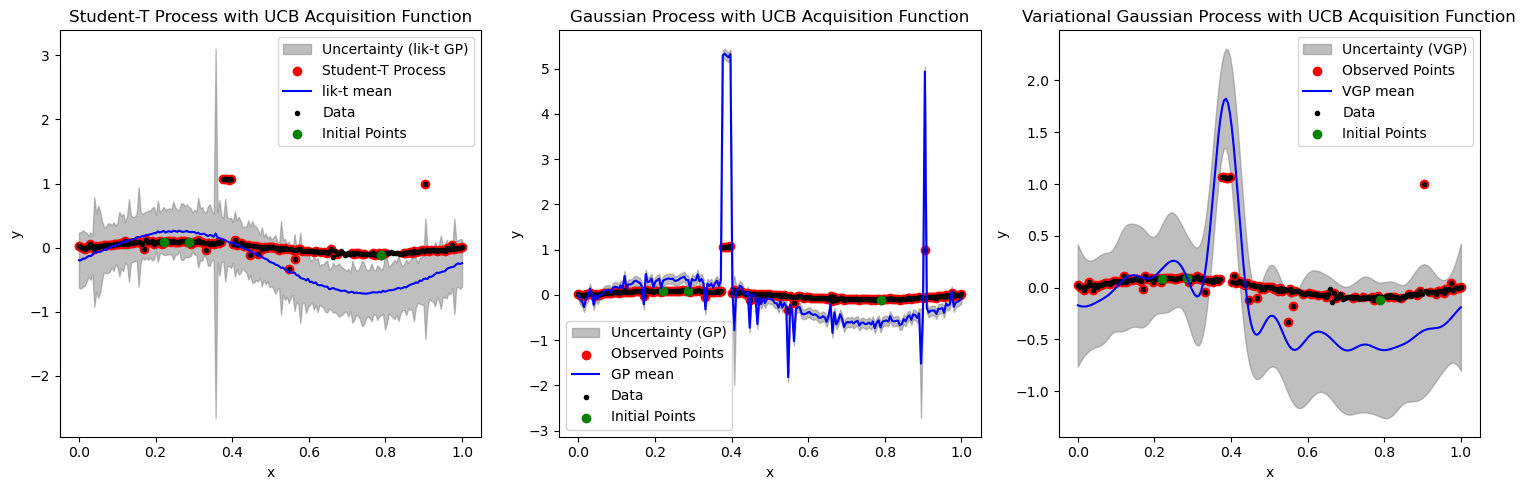

In [3]:

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# First subplot: Student-T Process
ax1.fill_between(train_x.numpy(), (meanSTP - 2*stdSTP).numpy(), (meanSTP + 2*stdSTP).numpy(), color='grey', alpha=0.5, label='Uncertainty (lik-t GP)')
ax1.scatter(train_xSTP.numpy(), train_ySTP.numpy(), c='red', label="Student-T Process")
ax1.plot(train_x.numpy(), meanSTP.numpy(), 'b-', label="lik-t mean")
ax1.scatter(train_x.numpy(), train_y.numpy(), c='k', marker='.', label="Data")
ax1.scatter(initialPoints, initialPointsy, c='green', marker='o', label="Initial Points")
ax1.legend(loc="best")
ax1.set(xlabel="x", ylabel="y", title="Student-T Process with "+ acqFunc + " Acquisition Function")

# Second subplot: Gaussian Process
ax2.fill_between(train_x.numpy(), (meanEGP - 2*stdEGP).numpy(), (meanEGP + 2*stdEGP).numpy(), color='grey', alpha=0.5, label='Uncertainty (GP)')
ax2.scatter(train_xEGP.numpy(), train_yEGP.numpy(), c='red', label="Observed Points")
ax2.plot(train_x.numpy(), meanEGP.numpy(), 'b-', label="GP mean")
ax2.scatter(train_x.numpy(), train_y.numpy(), c='k', marker='.', label="Data")
ax2.scatter(initialPoints, initialPointsy, c='green', marker='o', label="Initial Points")
ax2.legend(loc="best")
ax2.set(xlabel="x", ylabel="y", title="Gaussian Process with "+ acqFunc + " Acquisition Function")

# Third subplot: Variational Gaussian Process
ax3.fill_between(train_x.numpy(), (meanVGP - 2*stdVGP).numpy(), (meanVGP + 2*stdVGP).numpy(), color='grey', alpha=0.5, label='Uncertainty (VGP)')
ax3.scatter(train_xVGP.numpy(), train_yVGP.numpy(), c='red', label="Observed Points")
ax3.plot(train_x.numpy(), meanVGP.numpy(), 'b-', label="VGP mean")
ax3.scatter(train_x.numpy(), train_y.numpy(), c='k', marker='.', label="Data")
ax3.scatter(initialPoints, initialPointsy, c='green', marker='o', label="Initial Points")
ax3.legend(loc="best")
ax3.set(xlabel="x", ylabel="y", title="Variational Gaussian Process with " + acqFunc + " Acquisition Function")

# Adjust layout
plt.tight_layout()
plt.show()